In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math 

def radial_basis_function(x, grid_pnts, widths):
    """_summary_

    Args:
        x (_type_): _description_
        grid_pnts (_type_): _description_
        widths (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Calculate the squared Euclidean distance between x and each center
    activations = torch.exp( - ((x - grid_pnts) / widths) ** 2)
    return activations


class RBFLayer(nn.Module):
    def __init__(self, width=None,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, 
                 trainable_center=False,
                 trainable_width=False):
        super(RBFLayer, self).__init__()
        grid = torch.linspace(grid_min, grid_max, grid_size)
        self.centers = nn.Parameter(grid, requires_grad=trainable_center)
        if width is None:
            width = (grid_max - grid_min) / (grid_size - 1)
        self.width = nn.Parameter(torch.tensor(width, dtype=torch.float32), requires_grad=trainable_width)

    def forward(self, x):
        activations = torch.exp( - ((x[..., None] - self.centers) / self.width)**2)
        return activations


class RBFKANLayer(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 output_dim : int,
                 residual=True,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, width=None,
                 trainable_center=False,
                 trainable_width=False):
        super(RBFKANLayer, self).__init__()
        self.rbf = RBFLayer(width, grid_min, grid_max, grid_size, trainable_center, trainable_width)
        basis_coef = torch.randn(input_dim, grid_size) / math.sqrt(input_dim)
        self.basis_coef = nn.Parameter(basis_coef, requires_grad=True)
        self.residual = residual
        if residual:
            self.res_act = nn.SiLU()
        self.readout = nn.Linear(input_dim, output_dim)
        # self.basis_combined = nn.Linear(input_dim * grid_size, output_dim)
        

    def forward(self, x):
        rbf_act = self.rbf(x) # [batch_size, input_dim, grid_size]
        rbf_act = einops.einsum(rbf_act, self.basis_coef, 'B inp grid, inp grid -> B inp')
        if self.residual:
            rbf_act = rbf_act + self.res_act(x)
        out = self.readout(rbf_act)
        return out
        

class RBFKANnet(nn.Module):
    def __init__(self, layer_dim_list, residual=True, KAN_config=None):
        super(RBFKANnet, self).__init__()
        self.layers = nn.ModuleList()
        if KAN_config is None:
            KAN_config = {'grid_min': -2.0, 'grid_max': 2.0, 'grid_size': 10, 'width': None,
                          'trainable_center': False, 'trainable_width': False}
        for i in range(len(layer_dim_list) - 1):
            self.layers.append(RBFKANLayer(layer_dim_list[i], layer_dim_list[i+1], 
                                           residual=residual, **KAN_config))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage
rbf_layer = RBFLayer()
input_data = torch.randn(10, 2)
output = rbf_layer(input_data)
print(output.shape)
layer = RBFKANLayer(500, 50)
data = torch.randn(15, 500)
output = layer(data)
print(output.shape)
net = RBFKANnet([500, 50, 10])
output = net(data)
print(output.shape)

torch.Size([10, 2, 10])
torch.Size([15, 50])
torch.Size([15, 10])


In [4]:
net = RBFKANnet([1, 1], KAN_config={'grid_min': -3.0, 'grid_max': 3.0, 'grid_size': 20, 'width': None,})

Epoch [100/1000], Loss: 0.4018
Epoch [200/1000], Loss: 0.2798
Epoch [300/1000], Loss: 0.2397
Epoch [400/1000], Loss: 0.2176
Epoch [500/1000], Loss: 0.2025
Epoch [600/1000], Loss: 0.1911
Epoch [700/1000], Loss: 0.1823
Epoch [800/1000], Loss: 0.1752
Epoch [900/1000], Loss: 0.1695
Epoch [1000/1000], Loss: 0.1647


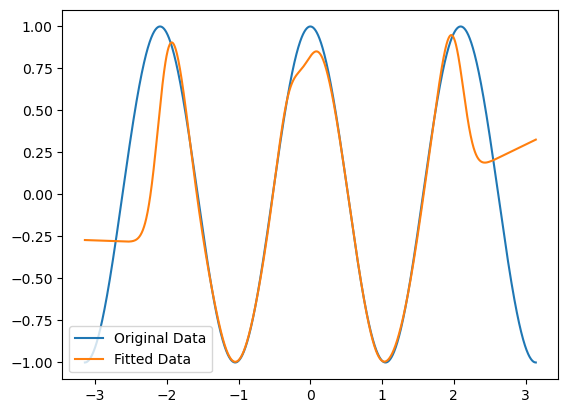

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Generate the dataset
x = np.linspace(-np.pi, np.pi, 2000)
y = np.cos(3*x)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# # Step 2: Define the neural network
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(1, 10)
#         self.fc2 = nn.Linear(10, 10)
#         self.fc3 = nn.Linear(10, 1)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = SimpleNet()
net = RBFKANnet([1, 1], KAN_config={'grid_min': -2.0, 'grid_max': 2.0, 'grid_size': 20, 'width': None,})


# Step 3: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
# Step 4: Train the neural network
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the results
predicted = net(x_tensor).detach().numpy()
plt.plot(x, y, label='Original Data')
plt.plot(x, predicted, label='Fitted Data')
plt.legend()
plt.show()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
MLP = nn.Sequential(
    nn.Linear(500, 64),
    nn.SiLU(),
    nn.Linear(64, 10)
)
print("Trainable parameters in RBFKANLayer:", count_parameters(layer))
print("Trainable parameters in RBFKANnet:", count_parameters(net))
print ("Trainable parameters in MLP:", count_parameters(MLP))

Trainable parameters in RBFKANLayer: 30050
Trainable parameters in RBFKANnet: 31060
Trainable parameters in MLP: 32714


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='~/Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/Datasets', train=False, download=True, transform=transform)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='~/Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='~/Datasets', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RBFKANnet([28 * 28, 50, 10]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Evaluate on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309544

Test set: Average loss: 0.0004, Accuracy: 8960/10000 (90%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.355956

Test set: Average loss: 0.0003, Accuracy: 9243/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.275057

Test set: Average loss: 0.0002, Accuracy: 9375/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200089

Test set: Average loss: 0.0002, Accuracy: 9447/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.214981

Test set: Average loss: 0.0002, Accuracy: 9521/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.147768

Test set: Average loss: 0.0001, Accuracy: 9563/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.134384

Test set: Average loss: 0.0001, Accuracy: 9603/10000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.113770

Test set: Average loss: 0.0001, Accuracy: 9642/10000 (96%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.099980

Test set: Average loss: 0.0001, Accuracy: 9663/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.082237



In [11]:
def train(model, train_dataset, test_dataset, train_batch, eval_batch, device, num_epochs=10, lr=0.005, testset_names=None):
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=eval_batch, shuffle=False)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    stats = {}
    epoch = -1
    stats[epoch] = {}
    if isinstance(test_dataset, list):
        for dataset, label in zip(test_dataset, testset_names):
            print(f"Evaluating on {label}", end="\t")
            eval_stats = eval_on_dataset(model, dataset, eval_batch, device)
            # add prefix to keys
            eval_stats = {f"{label}_{k}": v for k, v in eval_stats.items()}
            stats[epoch].update(eval_stats)
    else:
        eval_stats = eval_on_dataset(model, test_dataset, eval_batch, device)
        stats[epoch].update(eval_stats)
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Evaluate on the test set
        stats[epoch] = {}
        if isinstance(test_dataset, list):
            for dataset, label in zip(test_dataset, testset_names):
                print(f"Evaluating on {label}", end="\t")
                eval_stats = eval_on_dataset(model, dataset, eval_batch, device)
                # add prefix to keys
                eval_stats = {f"{label}_{k}": v for k, v in eval_stats.items()}
                stats[epoch].update(eval_stats)
        else:
            eval_stats = eval_on_dataset(model, test_dataset, eval_batch, device)
            stats[epoch].update(eval_stats)
        
    return model, stats

def eval_on_dataset(model, dataset, batch_size, device):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(dataset)} '
            f'({100. * correct / len(dataset):.0f}%)')
    acc = correct / len(dataset)
    return {"loss": test_loss, "accuracy": acc}

In [41]:
model = RBFKANnet([28 * 28, 50, 10]).to(device)
train(model, train_dataset, test_dataset, train_batch=2048, eval_batch=5000, device="cuda", num_epochs=10, lr=0.005)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.066652

Test set: Average loss: 0.0000, Accuracy: 9664/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.060082

Test set: Average loss: 0.0000, Accuracy: 9671/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051811

Test set: Average loss: 0.0000, Accuracy: 9691/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.041368

Test set: Average loss: 0.0000, Accuracy: 9688/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039568

Test set: Average loss: 0.0000, Accuracy: 9677/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032715

Test set: Average loss: 0.0000, Accuracy: 9690/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.033347

Test set: Average loss: 0.0000, Accuracy: 9700/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.028179

Test set: Average loss: 0.0000, Accuracy: 9692/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.027380

Test set: Average loss: 0.0000, Accuracy: 9695/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.019722



RBFKANnet(
  (layers): ModuleList(
    (0): RBFKANLayer(
      (rbf): RBFLayer()
      (res_act): SiLU()
      (readout): Linear(in_features=784, out_features=50, bias=True)
    )
    (1): RBFKANLayer(
      (rbf): RBFLayer()
      (res_act): SiLU()
      (readout): Linear(in_features=50, out_features=10, bias=True)
    )
  )
)

In [45]:
MLP = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.SiLU(),
    nn.Linear(64, 10)
)
train(MLP, train_dataset, test_dataset, train_batch=2048, eval_batch=5000, device="cuda", num_epochs=25, lr=0.005)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.322063

Test set: Average loss: 0.0001, Accuracy: 8777/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.395896

Test set: Average loss: 0.0001, Accuracy: 9064/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.360773

Test set: Average loss: 0.0001, Accuracy: 9130/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.328451

Test set: Average loss: 0.0001, Accuracy: 9210/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.306554

Test set: Average loss: 0.0001, Accuracy: 9303/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.245835

Test set: Average loss: 0.0000, Accuracy: 9327/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.212305

Test set: Average loss: 0.0000, Accuracy: 9347/10000 (93%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.231029

Test set: Average loss: 0.0000, Accuracy: 9448/10000 (94%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.175529

Test set: Average loss: 0.0000, Accuracy: 9449/10000 (94%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.144383



Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): SiLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)